In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
!nvidia-smi

Wed Dec  7 19:24:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 522.25       Driver Version: 522.25       CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   40C    P8     6W /  N/A |      0MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Importing Dependencies

In [3]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [4]:
import pickle
import glob
from PIL import Image

# Creating Test Dataloader

In [5]:
mean = 0.5184
std = 0.2531

# creating the train dataset and dataloader for calculating the mean and standard deviation of our samples
image_size = 64
batch_size = 4
CHANNELS_IMG = 1

stats = [mean for _ in range(CHANNELS_IMG)], [std for _ in range(CHANNELS_IMG)];stats

([0.5184], [0.2531])

In [6]:
class CustomDatasetWithPadding(Dataset):
    def __init__(self, data_dir, transforms):
        self.data = []
        self.transform = transforms
        self.targets = []
    
        class_list = os.listdir(data_dir) # ['Covid', 'Normal', 'Viral Pneumonia']
        for class_name in class_list:
            class_path = os.path.join(data_dir, class_name)
            for img_path in glob.glob(class_path + "/*.png"):
                self.data.append([img_path, class_name])
                
        self.available_classes = os.listdir(data_dir)
                        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = self.transform(Image.open(img_path))
        grey_image = np.zeros([1, 224, 224], dtype = np.float64)
        grey_image[:,80:144, 80:144] = img
        grey_image = torch.from_numpy(grey_image)
        grey_image = grey_image.type(torch.FloatTensor)
        # grey_image = grey_image.type(torch.cuda.FloatTensor)
        
        class_id = self.available_classes.index(class_name)
        class_id = torch.tensor(class_id)
        
        
        return grey_image, class_id

In [7]:
# following transformations will be performed on each image
transformations_to_perform = transform=tt.Compose([
                                tt.Grayscale(num_output_channels=1),
                                tt.Resize(image_size),
                                tt.ToTensor(),
                                tt.Normalize(*stats)])

val_data_dir = r'C:\Users\Lenovo\Desktop\FYP Coding\Covid-19 Dataset\Covid-19 Dataset\Validation'
test_data_dir = r'C:\Users\Lenovo\Desktop\FYP Coding\Covid-19 Dataset\Covid-19 Dataset\Test'


# Validation dataset
val_ds = CustomDatasetWithPadding(val_data_dir, transformations_to_perform)
val_dl = DataLoader(val_ds, batch_size, shuffle=True, pin_memory=True)

# Test dataset
test_ds = CustomDatasetWithPadding(test_data_dir, transformations_to_perform)
test_dl = DataLoader(test_ds, batch_size, shuffle=True, pin_memory=True)

# Using a GPU

In [8]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [9]:
device = get_default_device()
device

device(type='cuda')

In [10]:
# # transporting testing dataloaders to GPU

val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

# Importing ResNet50 model and loading pretrained weights

In [11]:
# importing our custom ResNet-50 model

from ResNet50 import ResNet, block

In [12]:
img_channel = 1
num_classes = 3


model = ResNet(block, [3, 4, 6, 3], img_channel, num_classes)
model = to_device(model, device)

In [13]:
# Loading pretrained weights

model.load_state_dict(torch.load('ResNet_50_Imbalanced.pth'))
model.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    

In [14]:
# %%time

# @torch.no_grad()
# def evaluate(model, val_loader):
#     model.eval()
#     outputs = [model.validation_step(batch) for batch in val_loader]
#     return model.validation_epoch_end(outputs)

# test_output = evaluate(model, test_dl)


# test_loss = test_output['val_loss']
# test_accuracy = test_output['val_acc']

# print("The final testing accuracy is: ",  test_accuracy)
# print("The final testing loss is: ",  test_loss)

# Visualizing the models performance while Training

In [15]:
import copy
import copy
from matplotlib import rc, rcParams
rc('font', weight='bold')

In [16]:
with open('history_imbalanced.pkl', 'rb') as f:
      history = pickle.load(f)

In [17]:
history[0].keys()

dict_keys(['val_loss', 'val_acc', 'train_loss', 'lrs'])

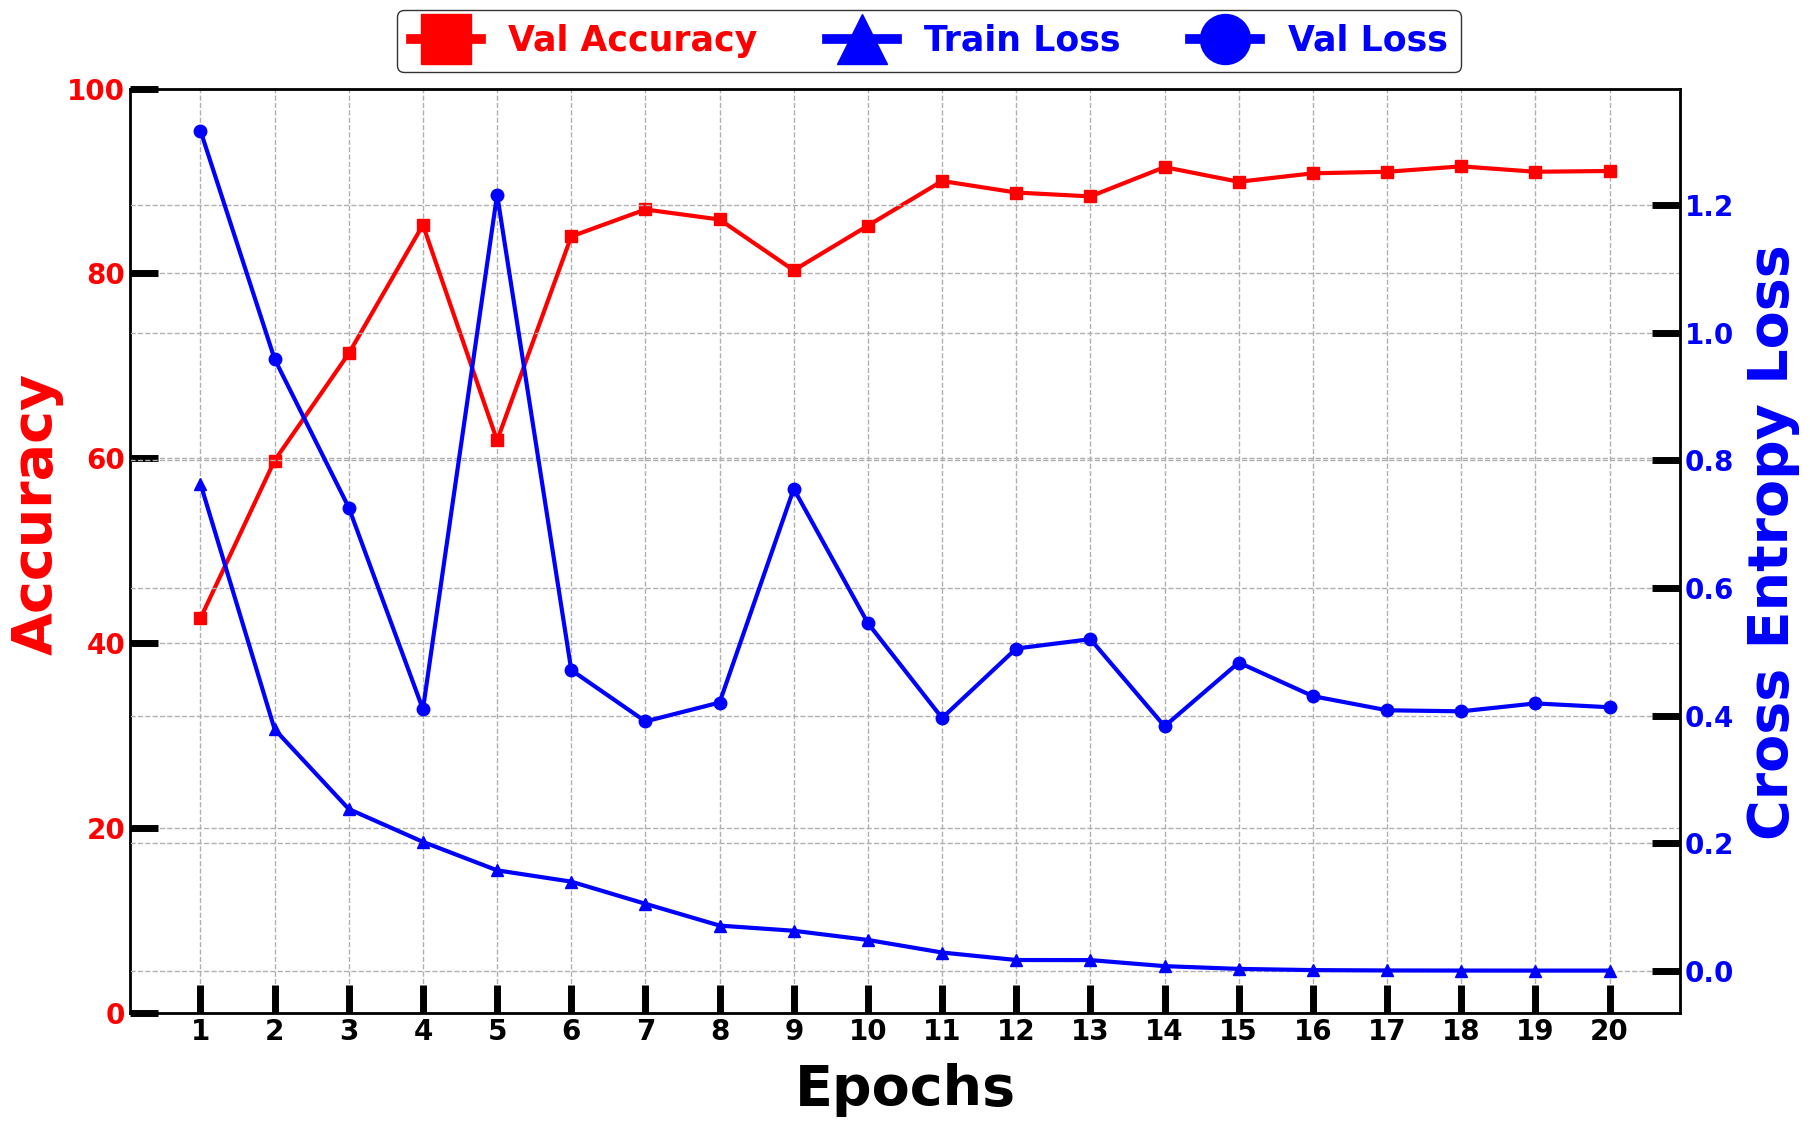

In [18]:
fig, axes = plt.subplots(1, 1, figsize=(20, 12))

ax1 = plt.subplot(1,1,1)
plot_1 = ax1.plot(range(1, 21), [x['val_acc'] for x in history], color = 'red', label = 'Val Accuracy',\
                 marker = 's', linewidth=3.0, markersize = 9)

ax1.tick_params(axis ='y', labelcolor = 'red',labelsize=20, width=8) 
ax1.tick_params(axis ='x', labelcolor = 'black',labelsize=20, width=8)
ax1.set_ylim([0, 100])
# ax1.set_xlim([0,21])


ax1a = ax1.twinx()
plot_2 = ax1a.plot(range(1, 21), [x['train_loss'] for x in history], color = 'blue', label = 'Train Loss',\
                   marker = '^', linewidth=3.0, markersize = 9)

plot_3 = ax1a.plot(range(1, 21), [x['val_loss'] for x in history], color = 'blue', label = 'Val Loss',\
                   marker = 'o', linewidth=3.0, markersize = 9)

ax1a.tick_params(axis ='y', labelcolor = 'blue',labelsize=20, width=8) 


# set various colors
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black') 
ax1.spines['right'].set_color('black')
ax1.spines['right'].set_linewidth(2)
ax1.spines['top'].set_linewidth(2)
ax1.spines['bottom'].set_linewidth(2)
ax1.spines['left'].set_color('black')
ax1.spines['left'].set_lw(2)



# for ax1 
ax1.tick_params(which='both', width=5)
ax1.tick_params(which='major', length=20)
ax1.tick_params(which='minor', length=5)
ax1.tick_params(which = 'both', direction = 'in')

# for ax1a
ax1a.tick_params(which='both', width=5)
ax1a.tick_params(which='major', length=20)
ax1a.tick_params(which='minor', length=5)
ax1a.tick_params(which = 'both', direction = 'in') 

ax1.grid(True, which = 'major', alpha = 1, linestyle='--', linewidth = 1)
ax1a.grid(True, which = 'major', alpha = 1, linestyle='--', linewidth = 1)


# Labels for legend
lns = plot_1 + plot_2+plot_3
labels = [l.get_label() for l in lns]
handles1, _ = ax1.get_legend_handles_labels()
handles2, _ = ax1a.get_legend_handles_labels()
handles = handles1 + handles2
handles = [copy.copy(ha) for ha in handles ]
[ha.set_linewidth(7) for ha in handles ]
leg = fig.legend(lns, labels, handles = handles,loc="upper left", bbox_to_anchor=(0.25,0.96),\
           fontsize = 25, ncol=3, markerscale=4, labelcolor='linecolor')
leg.get_frame().set_edgecolor('black')


ax1.text(-0.06, 0.4, 'Accuracy',horizontalalignment='center',transform=ax1.transAxes, \
         fontsize = 40, fontweight="bold", rotation = 'vertical', color = 'red')
ax1a.text(1.06, 0.2, 'Cross Entropy Loss',horizontalalignment='center',transform=ax1a.transAxes, \
         fontsize = 40, fontweight="bold", rotation = 'vertical', color = 'blue')
ax1a.text(0.5, -0.1, 'Epochs', horizontalalignment='center',transform=ax1a.transAxes, \
         fontsize = 40, fontweight="bold", rotation = 'horizontal', color = 'black')

ticks = range(1, 21)
new_xticks = [str(i) for i in range(1, 21)]
plt.xticks(ticks, new_xticks, fontsize =30);
# fig.savefig("ResNet50_Imbalanced_Training_Performance.jpg")

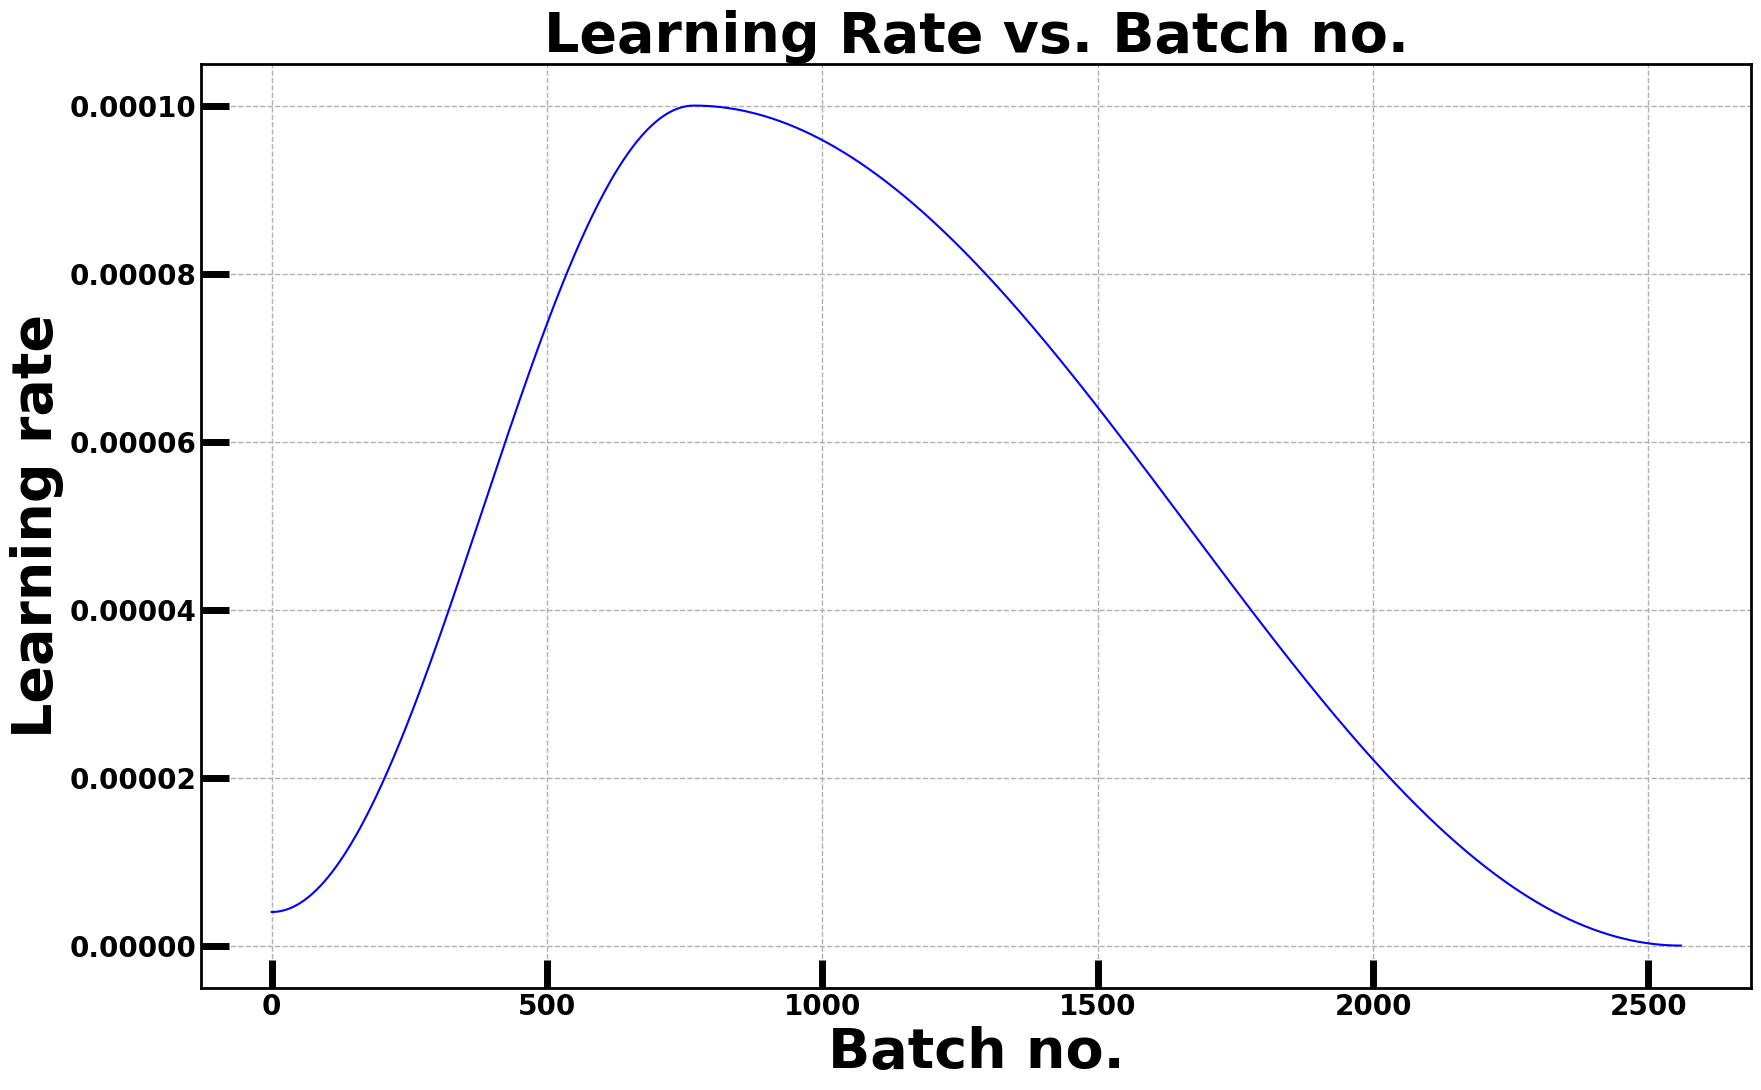

In [19]:
fig, axes = plt.subplots(1, 1, figsize=(20, 12))

ax1 = plt.subplot(1,1,1)
lrs = np.concatenate([x.get('lrs', []) for x in history])
plt.plot(lrs, color = 'blue')
plt.xlabel('Batch no.', fontweight = 'bold', fontsize = 40)
plt.ylabel('Learning rate', fontweight = 'bold', fontsize = 40)
plt.title('Learning Rate vs. Batch no.', fontweight = 'bold', fontsize = 40)
ax1.tick_params(axis ='y', labelcolor = 'black',labelsize=20, width=8) 
ax1.tick_params(axis ='x', labelcolor = 'black',labelsize=20, width=8)

# set various colors
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black') 
ax1.spines['right'].set_color('black')
ax1.spines['right'].set_linewidth(2)
ax1.spines['top'].set_linewidth(2)
ax1.spines['bottom'].set_linewidth(2)
ax1.spines['left'].set_color('black')
ax1.spines['left'].set_lw(2)



# for ax1 
ax1.tick_params(which='both', width=5)
ax1.tick_params(which='major', length=20)
ax1.tick_params(which='minor', length=5)
ax1.tick_params(which = 'both', direction = 'in')
 

ax1.grid(True, which = 'major', alpha = 1, linestyle='--', linewidth = 1);
# fig.savefig("ResNet50_Imbalanced_Training_Performance_lr_vs_batches.jpg")

# Checking performance on Test set

In [14]:
from tqdm import tqdm

In [15]:
actual_labels = []
predicted_probabilities = []
predicted_labels = []
predicted_probabilities_for_each_class = []

for images, labels in tqdm(test_dl):
   
    # make predictions
    yb = model(images)
    
    out = nn.Softmax(dim = 1)(yb)
    out = out.cpu()
        
    # Pick index with highest probability
    probabilities, preds  = torch.max(out, dim=1)
#     print(out)
    
    predicted_probabilities_for_each_class_local = list(np.array(out.detach()))
    probabilities = probabilities.cpu()
    preds = list(np.array(preds))
    probabilities = list(np.array(probabilities.detach()))
    
    actual_labels.append(list(np.array(labels.cpu())))
    predicted_probabilities.append(probabilities)
    predicted_labels.append(preds)
    predicted_probabilities_for_each_class.append(predicted_probabilities_for_each_class_local)
    
#     print('Predicted probabilities:', predicted_probabilities)
#     print('Predictions:           :', preds)
#     print("Actual labels:         :", actual_labels)
#     break

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:12<00:00, 23.58it/s]


In [16]:
predicted_labels = np.array(predicted_labels, dtype = int).reshape(-1)
actual_labels = np.array(actual_labels, dtype = int).reshape(-1)
# predicted_probabilities_for_each_class = np.array(predicted_probabilities_for_each_class)

In [17]:
from sklearn.metrics import accuracy_score

In [18]:
print("The testing accuracy is: {}".format(accuracy_score(actual_labels, predicted_labels)*100,\
                                           3))

The testing accuracy is: 91.41666666666667


In [19]:
predicted_probabilities_for_each_class = np.array([np.array([j.tolist() for j in i]) for i in predicted_probabilities_for_each_class])
predicted_probabilities_for_each_class = predicted_probabilities_for_each_class.reshape(1200, 3)

In [20]:
from sklearn.metrics import classification_report, roc_auc_score

In [21]:
print("TEST\n")
print(classification_report(actual_labels, predicted_labels))

TEST

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       400
           1       0.86      0.96      0.91       400
           2       0.98      0.85      0.91       400

    accuracy                           0.91      1200
   macro avg       0.92      0.91      0.91      1200
weighted avg       0.92      0.91      0.91      1200



In [22]:
roc_auc_score(actual_labels, predicted_probabilities_for_each_class, multi_class='ovr')

0.9874713541666668

In [23]:
roc_auc_score(actual_labels, predicted_probabilities_for_each_class, multi_class='ovo')

0.9874713541666668

## Confusion Matrix

In [24]:
actual_labels

array([2, 1, 2, ..., 2, 1, 0])

In [25]:
predicted_labels

array([2, 1, 2, ..., 2, 1, 0])

In [26]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
from matplotlib import rc, rcParams
rc('font', weight='bold')

In [27]:
classes = ['Covid', 'Normal', 'Viral Pneumonia']

In [28]:
cf_matrix = confusion_matrix(actual_labels, predicted_labels)
dataframe = pd.DataFrame(cf_matrix, index = classes, columns = classes)

In [30]:
import pickle

with open('CM_ResNet50_Imbalanced.pkl', 'wb') as f:
       pickle.dump(dataframe, f)

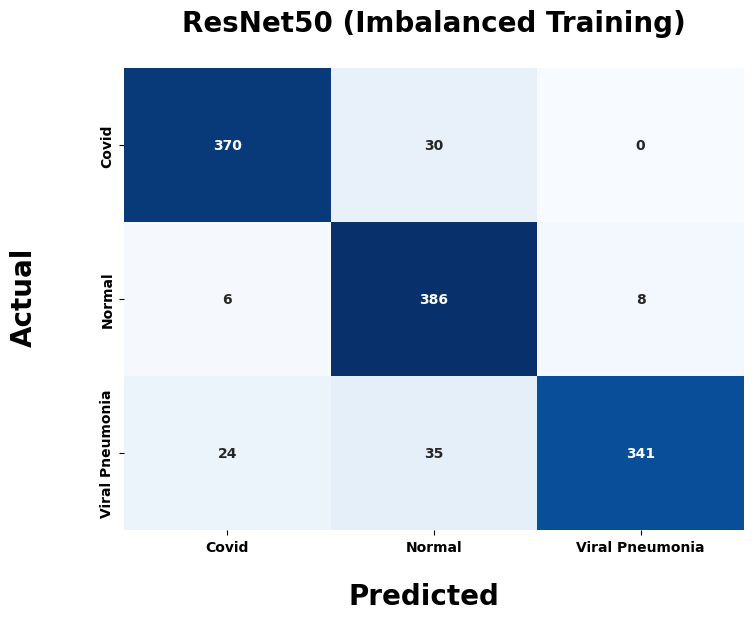

In [36]:
fig, axes = plt.subplots(1, 1, figsize=(8, 6))

ax1 = plt.subplot(1, 1, 1)

sns.heatmap(dataframe, cmap="Blues", annot = True, fmt="d", cbar =False)
fig.text(0.5, 0.00, 'Predicted', ha='center', va='center', fontsize = 20)
fig.text(0.0, 0.5, 'Actual', ha='center', va='center', rotation='vertical', fontsize = 20)
ax1.text(0.5, 1.08, 'ResNet50 (Imbalanced Training)',
    horizontalalignment='center',
    fontsize=20,
    transform = ax1.transAxes);

### For class 0 (Covid)

For True positive, the actual and predicted values must be same. Therefore, for this class, the value of cell 1 is the TP
True positive means that the actual target is positive and the model also predicted that particular class.

In [37]:
TP = 370

For False Negative of class 0, we will add corresponding values in first row except cell 1. False Negative means that model predicted negative but the actual target if positive.

In [38]:
FN = 30

For False Positive of class 0, we will add all values of correponding column except for True Positive value.

FP = (cell 4 + cell 7)

False positive means model predicted positive class and it is an incorrect prediction

In [39]:
FP = 6 + 24;FP

30

For True Negatives, we will calculate the sum of values of all columns and row except the values of that class that we are calculating the values for.

TN = (cell 5 + cell 6 + cell 8 + cell 9)

True negative means model made negative prediction and it is a correct prediction

In [40]:
TN = 386 + 8 + 35 + 341

In [41]:
print("For Class 0 (Covid): ")
print("True Positives: ", TP)
print("True Negatives: ", TN)
print("False_Positive: ", FP)
print("False_Negative: ", FN)

For Class 0 (Covid): 
True Positives:  370
True Negatives:  770
False_Positive:  30
False_Negative:  30


<B> Precision
    
- > Precision tells us among the positive predictions made by our model, what proportion of them are actually correct(or positive)

In [42]:
precision_class_0 = TP / (TP + FP);precision_class_0

0.925

The precision of model for class Covid is 92.5 % means that when our model predicts Covid class for an x-ray, it is correct 92.5 % of the times.

<b> Sensitivity or Recall or True Positive Rate</b>
- > Recall tells us among all the positive targets in test dataset, what proportion of those positive classes were correctly identified or predicted

Sensitivity (true positive rate) refers to the probability of a positive test, conditioned on truly being positive.


In [43]:
recall_class_0 = TP / (TP + FN);recall_class_0

0.925

Here, a recall score of 92.5 % for class Covid means it correctly identifies 92.5 % of Covid class x-rays.

Understand the difference between Precision and Recall [here](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall).

<b> F1 Score
    
- > F1 Score is the harmonic mean or weighted average of Precision and Recall. Mathematically, F1 Score would look like:

              2 * Recall * Precision / (Recall + Precision)
    
In other words, we would like to summarize the models’ performance into a single metric. That’s where F1-score are used. It’s a way to combine precision and recall into a single number.
    
Similar to arithmetic mean, the F1-score will always be somewhere in between precision and recall.

In [44]:
f1_score_class_0 = 2 * (recall_class_0 * precision_class_0) / (recall_class_0 + precision_class_0);
f1_score_class_0

0.925

The F1 Score of our model is 0.925 means that the model’s ability to both capture positive cases and be accurate with the cases it does capture is 0.925.

F1 score tells you the model’s balanced ability to both capture positive cases (recall) and be accurate with the cases it does capture (precision).

<b> Specificity or True Negative Rate</b>

- > When the actual value is negative, how often is the prediction made by our model correct is given by Specificity.




In [45]:
specificity_class_0 = TN / (TN + FP);specificity_class_0

0.9625

Here, a Specificity is almost 96.3 % indicates that if our model makes a negative class prediction(not class <b> Covid </b>), it is correct 96.3 % of the times. 

<b> False Positive Rate
    
- > When an actual value is negative, how often is the prediction made by our model incorrect is given by the False Positive Rate.
    
    
FPR = 1 - specificity (TNR)

In [46]:
fpr_class_0 = FP / (FP + TN);fpr_class_0

0.0375

Here, the false positive rate of the model for class <b> Covid </b> is roughly 0.04 means that if a model makes a covid class prediction, but in fact the target is not class covid, the model is incorrect roughly 4 % of the times.

<b> False Negative Rate
    
- > When an actual value is positive, how often is the preduction made by our model is incorrect is given by FNR.

In [47]:
fnr_class_0 = FN / (FN + TP);fnr_class_0

0.075

Here, the false negative rate of the model for class <b> Covid </b> is roughly 0.075 means that if a model makes a not covid class prediction, but in fact the target is  class covid, the model is incorrect roughly 7.5 % of the times.

### ROC Curve and AUC Score for all classes

The ROC curve stands for `Receiver Operator Characteristics` curve that is one of the most important evaluation metric for a classification problem like this project. It is a probability curve in which True Positive Rate is plotted in y-axis and False positive Rate is plotted on x-axis at all classification thresholds. Similarly, the Area Under the Curve(AUC) is the measure of the ability of a classification model to predict correct classes. Therefore, the higher is the AUC, the better will be the model's performance to predict positive and negative classes respectively.

Before plotting the curve, lets calculate the True Positive Rate(TPR) and False Positive Rate(FPR).

```
A TPR helps us to understand the proportion of the positive class predictions that were correct. 
TPR = sensitivity = TP / (TP  + FN)

Similarly, False Positive Rate(FPR) helps us to understand the proportion of 
the negative class predictions that were incorrectly predicted by our Logistic Regression model.

FPR = 1 - specificity = FP / (TN + FP)
```

Here, if a model has a higher TPR, the ability of a model to recognize positive classes will be higher. Similarly, we know `True Negative Rate(TNR) ` = 1 - FPR. Therefore, a lower FPR means higher TNR. If our model has a higher TNR, our model will also be able to recognize negativce classes with higher accuracy.

Therefore, higher TNR and TPR will result in our model to properly differentiate between positive and negative classes. Therefore, a ROC curve will help us visualize our model sensitivity and specificity with respect to different threshold probabilities to seperate between positive and negative classes.


In [48]:
from sklearn.metrics import roc_curve

In [49]:
fprs = {}
tprs = {}
thresholds ={}

In [50]:
# Using for loop for calculating false positive rate, true positive rate, and thresholds for all individual class and their probabilities
for i in range(3):    
    fprs[i], tprs[i], thresholds[i] = roc_curve(actual_labels, predicted_probabilities_for_each_class[:,i], pos_label=i)

# actual_labels, predicted_probabilities_for_each_class

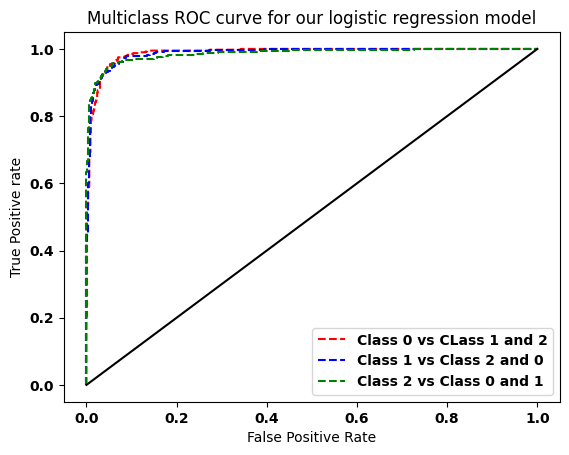

In [51]:
# plotting  the roc curve for each class
plt.title('Multiclass ROC curve for our logistic regression model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.plot(fprs[0], tprs[0], linestyle='--',color='red', label='Class 0 vs CLass 1 and 2')
plt.plot(fprs[1], tprs[1], linestyle='--',color='blue', label='Class 1 vs Class 2 and 0')
plt.plot(fprs[2], tprs[2], linestyle='--',color='green', label='Class 2 vs Class 0 and 1') 
plt.plot([0, 1], [0, 1], color="black")
plt.legend();
#plt.legend(['Class 0 -> Not survived', ' Class 1 -> Survived', 'Class 2 -> Injured'])


<b> AUC Score
- > The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve. The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes.

In [52]:
print("The AUC score  measured by one class versus rest classes is: ", roc_auc_score(actual_labels, predicted_probabilities_for_each_class, multi_class='ovr'))

The AUC score  measured by one class versus rest classes is:  0.9874713541666668


# Custom function

In [53]:
metrics_df = pd.DataFrame({'Model': [], 'Train_Condition': [],'Class' : [],'TP': [], 'FP': [], 'FN': [],'TN':[], 'Recall': [],'Precision': [],\
                           'Specificity': [],'FPR': [], 'FNR': [], 'f1_score': [], 'Accuracy': [], 'AUC': []})

hold_fprs_tprs_df = pd.DataFrame({'Model': [], 'Train_Condition': [], 'Class': [],'fprs': [], 'tprs': []})

In [54]:
metrics_df_columns = metrics_df.columns

In [55]:
hold_fprs_tprs_df.columns

Index(['Model', 'Train_Condition', 'Class', 'fprs', 'tprs'], dtype='object')

In [56]:
from sklearn.metrics import accuracy_score

In [63]:
def metrics(cm, targets, preds, predicted_probabilities, model_name):
    # for class Covid
    TP_Covid = cm[0][0]
    TN_Covid = sum(cm[1][1:]) + sum(cm[2][1:])
    FP_Covid = cm[1][0] + cm[2][0]
    FN_Covid = cm[0][1] + cm[0][2]
    
    # for class Normal
    TP_Normal = cm[1][1]
    TN_Normal = cm[0][1] + cm[0][2] + cm[2][0] + cm[2][2]
    FP_Normal = cm[0][1] + cm[2][1]
    FN_Normal = cm[1][0] + cm[1][2]
    
    # for class ViralPneumonia
    TP_ViralPneumonia = cm[2][2]
    TN_ViralPneumonia = cm[0][0] + cm[1][0] + cm[0][1] + cm[1][1]
    FP_ViralPneumonia = cm[0][2] + cm[1][2]
    FN_ViralPneumonia = cm[2][0] + cm[2][1]
    
    # precision
    precision_class_0 = round(TP_Covid / (TP_Covid + FP_Covid), 4)
    precision_class_1 = round(TP_Normal / (TP_Normal + FP_Normal), 4)
    precision_class_2 = round(TP_ViralPneumonia / (TP_ViralPneumonia + FP_ViralPneumonia), 4)
    
    
    # Recall / FPR / Sensitivity
    recall_class_0 = round(TP_Covid / (TP_Covid + FN_Covid), 4)
    recall_class_1 = round(TP_Normal / (TP_Normal + FN_Normal), 4)
    recall_class_2 = round(TP_ViralPneumonia / (TP_ViralPneumonia + FN_ViralPneumonia), 4)
    
    # F1 Score
    f1_score_class_0 = round(2 * (recall_class_0 * precision_class_0) / (recall_class_0 + precision_class_0), 4)
    f1_score_class_1 = round(2 * (recall_class_1 * precision_class_1) / (recall_class_1 + precision_class_1), 4)
    f1_score_class_2 = round(2 * (recall_class_2 * precision_class_2) / (recall_class_2 + precision_class_2), 4)
    
    # Specificity / True Negative Rate
    specificity_class_0 = round(TN_Covid / (TN_Covid + FP_Covid), 4)
    specificity_class_1 = round(TN_Normal / (TN_Normal + FP_Normal), 4)
    specificity_class_2 = round(TN_ViralPneumonia / (TN_ViralPneumonia + FP_ViralPneumonia), 4)
    
    # False Positive Rate
    fpr_class_0 = round(FP_Covid / (FP_Covid + TN_Covid), 4)
    fpr_class_1 = round(FP_Normal / (FP_Normal + TN_Normal), 4)
    fpr_class_2 = round(FP_ViralPneumonia / (FP_ViralPneumonia + TN_ViralPneumonia), 4)
    
    
    # False Negative Rate
    fnr_class_0 =  round(FN_Covid / (FN_Covid + TP_Covid), 4)
    fnr_class_1 =  round(FN_Normal / (FN_Normal + TP_Normal), 4)
    fnr_class_2 =  round(FN_ViralPneumonia / (FN_ViralPneumonia + TP_ViralPneumonia), 4)

    # Calculating False positive rates and True Positive Rates
    fprs = {}
    tprs = {}
    thresholds ={}

    for i in range(3):    
        fprs[i], tprs[i], thresholds[i] = roc_curve(targets, predicted_probabilities[:,i], pos_label=i)
        
        
#     auc_score_ovr = round(roc_auc_score(targets, predicted_probabilities, multi_class='ovr'), 4)
    auc_score_ovr = roc_auc_score(actual_labels, predicted_probabilities_for_each_class, multi_class='ovr', average = None)
    auc_score_ovr = [round(i, 4) for i in auc_score_ovr]
    
    accuracy =  round(accuracy_score(targets, preds), 4)
    

    array_0 = np.array([model_name, 'Imbalanced','Covid',TP_Covid, FP_Covid, FN_Covid, TN_Covid, recall_class_0, precision_class_0, \
                        specificity_class_0, fpr_class_0, fnr_class_0, f1_score_class_0, \
                        accuracy, auc_score_ovr[0]])
    
    array_1 = np.array([model_name, 'Imbalanced', 'Normal',TP_Normal, FP_Normal, FN_Normal, TN_Normal, recall_class_1, precision_class_1, \
                    specificity_class_1, fpr_class_1, fnr_class_1, f1_score_class_1, \
                    accuracy, auc_score_ovr[1]])
        
    array_2 = np.array([model_name, 'Imbalanced','Viral Pneumonia',TP_ViralPneumonia, FP_ViralPneumonia, FN_ViralPneumonia, TN_ViralPneumonia, \
                        recall_class_2, precision_class_2, specificity_class_2, fpr_class_2, \
                        fnr_class_2, f1_score_class_2, accuracy, auc_score_ovr[2]])
    
    
    arr_0 = [[model_name for i in range(len(fprs[0]))], ['Imbalanced' for i in range(len(fprs[0]))], \
             ['Covid' for i in range(len(fprs[0]))], fprs[0], tprs[0]]
    arr_0 = pd.DataFrame(arr_0).T 
    
    arr_1 = [[model_name for i in range(len(fprs[1]))], ['Imbalanced' for i in range(len(fprs[1]))], \
             ['Normal' for i in range(len(fprs[1]))], fprs[1], tprs[1]]
    arr_1 = pd.DataFrame(arr_1).T
    
    arr_2 = [[model_name for i in range(len(fprs[2]))], ['Imbalanced' for i in range(len(fprs[2]))], \
             ['Viral Pneumonia' for i in range(len(fprs[2]))], fprs[2], tprs[2]]
    arr_2 = pd.DataFrame(arr_2).T
    
    
    arr_123 = pd.concat([arr_0, arr_1, arr_2]).reset_index(drop = True)
    arr_123.columns = hold_fprs_tprs_df.columns
    
    
    temp = pd.DataFrame(array_0).T
    temp.columns = metrics_df_columns
    temp.loc[1] = array_1
    temp.loc[2] = array_2
    
    return arr_123, temp

In [64]:
arr_123, temp = metrics(cf_matrix, actual_labels, predicted_labels, predicted_probabilities_for_each_class, 'ResNet50')

In [65]:
arr_123

,Model,Train_Condition,Class,fprs,tprs
0,ResNet50,Imbalanced,Covid,0.0,0.0
1,ResNet50,Imbalanced,Covid,0.0,0.0425
2,ResNet50,Imbalanced,Covid,0.0,0.055
3,ResNet50,Imbalanced,Covid,0.0,0.0775
4,ResNet50,Imbalanced,Covid,0.0,0.0875
...,...,...,...,...,...
487,ResNet50,Imbalanced,Viral Pneumonia,0.825,1.0
488,ResNet50,Imbalanced,Viral Pneumonia,0.945,1.0
489,ResNet50,Imbalanced,Viral Pneumonia,0.9475,1.0
490,ResNet50,Imbalanced,Viral Pneumonia,0.9975,1.0


In [66]:
arr_123.to_csv('ResNet50_Imbalanced_Fprs_Tprs.csv', index = True)

In [57]:
temp.to_csv('ResNet50_Imbalanced_metrics.csv', index = True)

In [58]:
temp

,Model,Train_Condition,Class,TP,FP,FN,TN,Recall,Precision,Specificity,FPR,FNR,f1_score,Accuracy,AUC
0,ResNet50,Imbalanced,Covid,370,30,30,770,0.925,0.925,0.9625,0.0375,0.075,0.925,0.9142,0.9883
1,ResNet50,Imbalanced,Normal,386,65,14,395,0.965,0.8559,0.8587,0.1413,0.035,0.9072,0.9142,0.988
2,ResNet50,Imbalanced,Viral Pneumonia,341,8,59,792,0.8525,0.9771,0.99,0.01,0.1475,0.9106,0.9142,0.986
